# SART-TV
Based on the ASD-POCS algorithm

[1] Sidky, Emil Y., and Xiaochuan Pan. "Image reconstruction in circular cone-beam computed tomography by constrained, total-variation minimization." Physics in Medicine & Biology 53.17 (2008): 4777.

In [2]:
import glob, os, sys
import numpy as np
import logging
import time
import matplotlib.pyplot as plt

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    my_directory = '[[MY_Google_drive_directory]]'
    os.chdir(f'/content/drive/MyDrive/{my_directory}')
    !pip install pycuda

from Reconstruction_pycuda import Reconstruction

pi = np.pi
sqrt = np.sqrt
logging.basicConfig(level = logging.INFO)
log = logging.getLogger(__name__)
log.setLevel(logging.DEBUG)

In [3]:
nn = 256
NumberOfDetectorPixels = [512, 384] 
NumberOfViews = 90

showImage = False

Niter = 6
beta = 1.0
beta_red = 0.999
na = 5
ng = 20
alpha = 0.007
r_max = 0.99
alpha_red = 0.95

params = {'SourceInit': [0, 1000.0, 0], 'DetectorInit': [0, -500.0, 0], 'StartAngle': 0, 'EndAngle': 2 * pi,
          'NumberOfDetectorPixels': NumberOfDetectorPixels, 'DetectorPixelSize': [0.5, 0.5], 'NumberOfViews': NumberOfViews,
          'ImagePixelSpacing': [0.5, 0.5, 0.5], 'NumberOfImage': [nn, nn, nn], 'PhantomCenter': [0, 0, 0],
          'RotationOrigin': [0, 0, 0], 'ReconCenter': [0, 0, 0], 'Method': 'Distance', 'FilterType': 'hann',
          'cutoff': 1, 'GPU': 1, 'DetectorShape': 'Flat', 'Pitch': 0, 'DetectorOffset': [0, 0]}

R = Reconstruction(params)

In [4]:
savedir = 'results'
projname = os.path.join(savedir, f'proj_SheppLogan_({NumberOfDetectorPixels[0]}x{NumberOfDetectorPixels[1]}x{NumberOfViews}).raw')

filename = os.path.join('phantoms', f'Shepp_Logan_3d_({nn}x{nn}x{nn}).raw')
ph = np.fromfile(filename, dtype=np.float32).reshape([nn, nn, nn])

R.LoadProj(projname)
proj0 = R.proj

### Total variation

In [5]:
def tv_grad(image):
    eps = 1e-5
    w1 = image[1:-1, 1:-1, 1:-1] - image[0:-2, 1:-1, 1:-1]
    w2 = image[1:-1, 1:-1, 1:-1] - image[1:-1, 0:-2, 1:-1]
    w3 = image[1:-1, 1:-1, 1:-1] - image[1:-1, 1:-1, 0:-2]
    t1 = (w1 + w2 + w3) / (sqrt(eps + w1 ** 2 + w2 ** 2 + w3 ** 2))
    w4 = image[2:, 1:-1, 1:-1] - image[1:-1, 1:-1, 1:-1]
    w5 = image[2:, 1:-1, 1:-1] - image[2:, 0:-2, 1:-1]
    w6 = image[2:, 1:-1, 1:-1] - image[2:, 1:-1, 0:-2]
    t2 = (-w4) / (sqrt(eps + w4 ** 2 + w5 ** 2 + w6 ** 2))
    w7 = image[1:-1, 2:, 1:-1] - image[0:-2, 2:, 1:-1]
    w8 = image[1:-1, 2:, 1:-1] - image[1:-1, 1:-1, 1:-1]
    w9 = image[1:-1, 2:, 1:-1] - image[1:-1, 2:, 0:-2]
    t3 = (-w8) / (sqrt(eps + w7 ** 2 + w8 ** 2 + w9 ** 2))
    w10 = image[1:-1, 1:-1, 2:] - image[0:-2, 1:-1, 2:]
    w11 = image[1:-1, 1:-1, 2:] - image[1:-1, 0:-2, 2:]
    w12 = image[1:-1, 1:-1, 2:] - image[1:-1, 1:-1, 1:-1]
    t4 = (-w12) / (sqrt(eps + w10 ** 2 + w11 ** 2 + w12 ** 2))
    dtv = t1 + t2 + t3 + t4
    tv_norm = sqrt(np.sum(dtv ** 2))
    if (np.abs(tv_norm) < eps): tv_norm = 1.0
    dtv /= tv_norm

    dtv = np.pad(dtv, ((1, 1), (1, 1), (1, 1)), 'constant')
    return dtv


### SART-TV

In [6]:
eps = 1e-5
norm1 = Reconstruction(params)
norm1.proj = np.ones(
    [params['NumberOfViews'], params['NumberOfDetectorPixels'][1], params['NumberOfDetectorPixels'][0]],
    dtype=np.float32)
norm1.backward()
norm2 = Reconstruction(params)
norm2.image = np.ones(params['NumberOfImage'])
norm2.forward()


![ASD_POCS algorithm](images/ASD_POCS.png)

In [7]:
rmse = np.zeros(Niter, dtype=np.float32)
start_time = time.time()

for i in range(Niter):
    log.info(f'iter: {i}')
    f0 = np.copy(R.image)
    for a in range(na):
        recon_tmp = np.copy(R.image)
        R.forward()
        R.proj = (proj0 - R.proj) / (norm2.proj + eps)
        R.backward()
        R.image = recon_tmp + beta * R.image / (norm1.image + eps)

    dp = np.sqrt(np.sum((R.image - f0) ** 2))  # adist
    dtvg = alpha * dp

    f0 = np.copy(R.image)
    for g in range(ng):
        dtv = tv_grad(R.image)
        R.image = R.image - dtvg * dtv
    
    dg = np.sqrt(np.sum((R.image - f0) ** 2))  # gdist
    
    if (dg > r_max * dp):
        alpha *= alpha_red
    beta *= beta_red

    log.debug(f'dtvg: {dtvg:.3f} beta: {beta:.3f} dp: {dp:.3f} dg: {dg:.3f}')
    rmse[i] = np.sqrt(np.mean((R.image - ph) ** 2))
    log.info(f'RMSE: rmse[i]')


log.info(f'SART-TV: {time.time() - start_time:.3f} sec')
R.SaveRecon(os.path.join(savedir, f'Recon_SheppLogan_sart_tv_iter{Niter}_({R.image.shape[2]}x{R.image.shape[1]}x{R.image.shape[0]}).raw'))

INFO:__main__:iter: 0
DEBUG:__main__:dtvg: 3.694 beta: 0.999 dp: 527.665 dg: 12.535
INFO:__main__:0.13922395
INFO:__main__:iter: 1
DEBUG:__main__:dtvg: 0.754 beta: 0.998 dp: 107.723 dg: 10.176
INFO:__main__:0.123354554
INFO:__main__:iter: 2
DEBUG:__main__:dtvg: 0.480 beta: 0.997 dp: 68.517 dg: 8.708
INFO:__main__:0.11253531
INFO:__main__:iter: 3
DEBUG:__main__:dtvg: 0.363 beta: 0.996 dp: 51.908 dg: 6.785
INFO:__main__:0.104040466
INFO:__main__:iter: 4
DEBUG:__main__:dtvg: 0.293 beta: 0.995 dp: 41.814 dg: 5.570
INFO:__main__:0.09708701
INFO:__main__:iter: 5
DEBUG:__main__:dtvg: 0.244 beta: 0.994 dp: 34.864 dg: 4.711
INFO:__main__:0.091262564
INFO:__main__:SART-TV: 214.661 sec


### Show and compare

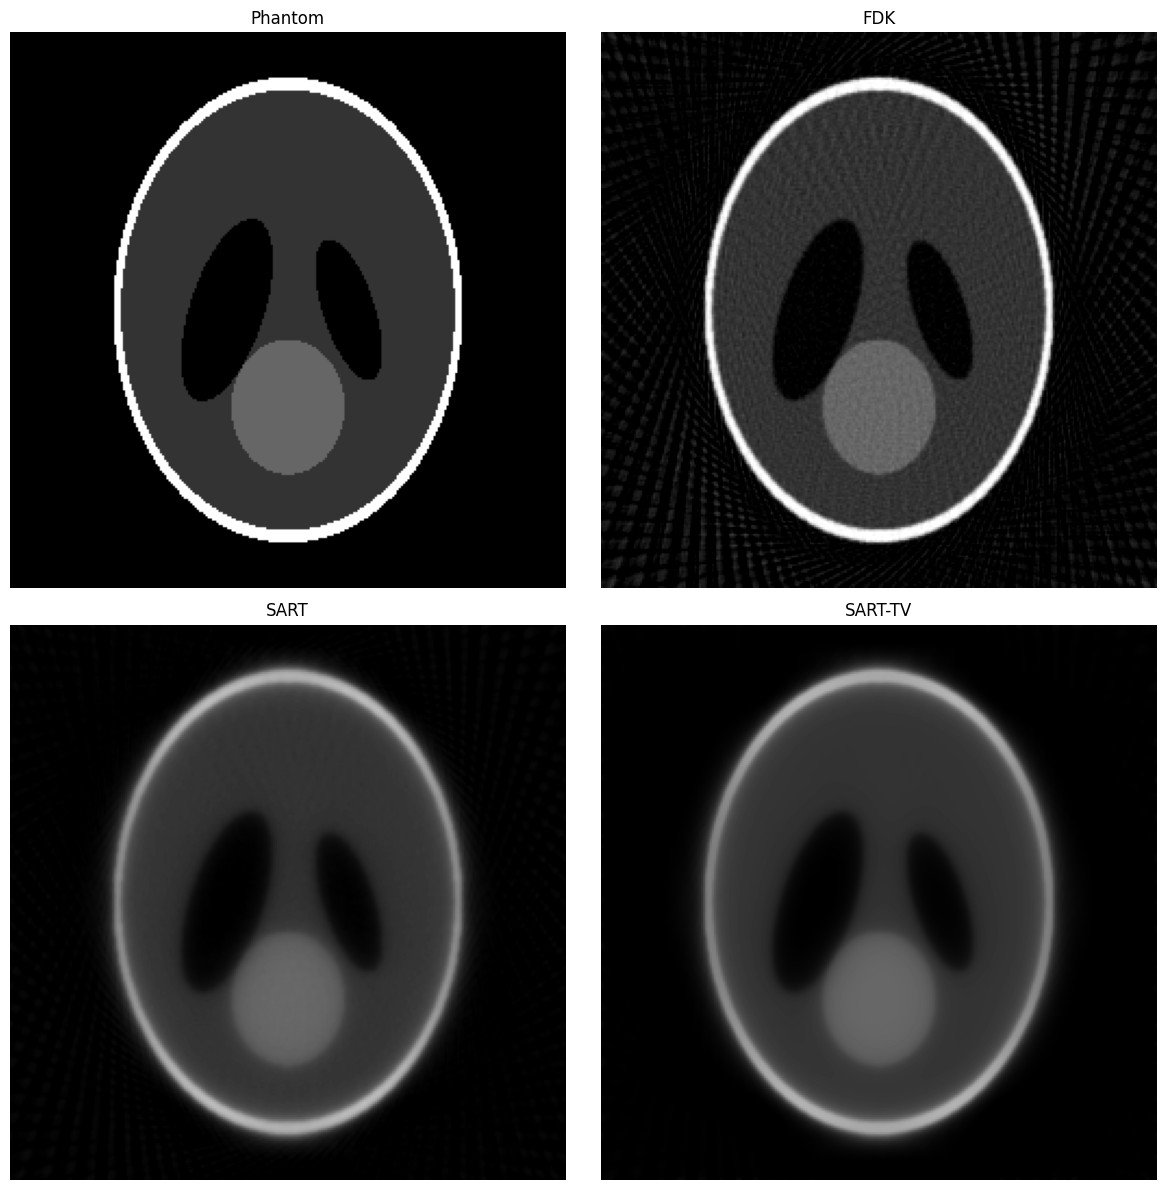

TypeError: only integer scalar arrays can be converted to a scalar index

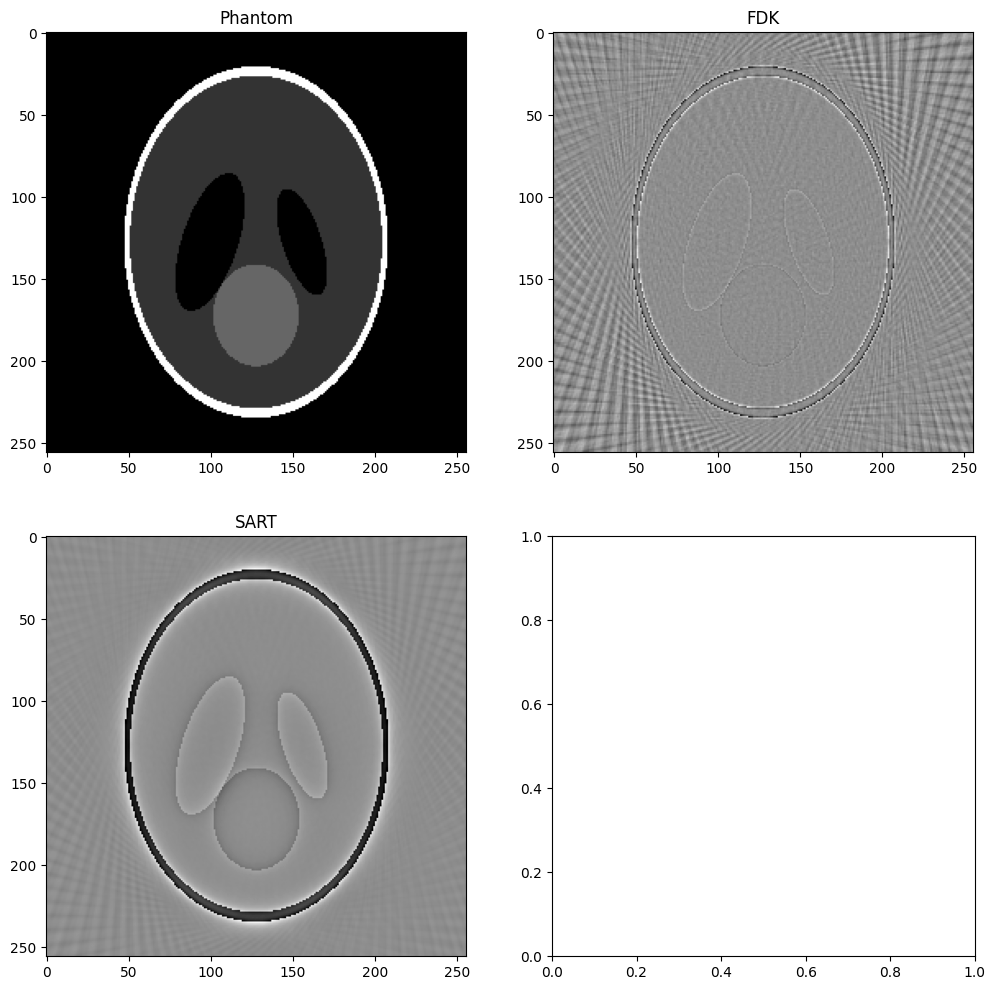

In [8]:
fdk = np.fromfile(os.path.join(savedir, f'Recon_SheppLogan_fdk_({R.image.shape[2]}x{R.image.shape[1]}x{R.image.shape[0]}).raw'), dtype = np.float32).reshape([nn, nn, nn])
sart = np.fromfile(os.path.join(savedir, f'Recon_SheppLogan_sart_iter{Niter * na}_({R.image.shape[2]}x{R.image.shape[1]}x{R.image.shape[0]}).raw'), dtype = np.float32).reshape([nn, nn, nn])

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax[0, 0].imshow(ph[81,:,:], cmap='gray', vmin=0, vmax=np.max(ph))
ax[0, 0].set_title('Phantom')
ax[0, 1].imshow(fdk[81,:,:], cmap='gray', vmin=0, vmax=np.max(ph))
ax[0, 1].set_title(f'FDK')
ax[1, 0].imshow(sart[81,:,:], cmap='gray', vmin=0, vmax=np.max(ph))
ax[1, 0].set_title(f'SART')
ax[1, 1].imshow(R.image[81,:,:], cmap='gray', vmin=0, vmax=np.max(ph))
ax[1, 1].set_title(f'SART-TV')
for a in ax.flatten():
    a.axis('off')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax[0, 0].imshow(ph[81,:,:], cmap='gray')
ax[0, 0].set_title('Phantom')
diff_fdk = fdk[81,:,:] - ph[81,:,:]
ax[0, 1].imshow(fdk[81,:,:] - ph[81,:,:], cmap='gray', vmin = np.min(diff_fdk), vmax = np.max(diff_fdk))
ax[0, 1].set_title(f'FDK')
ax[1, 0].imshow(sart[81,:,:] - ph[81,:,:], cmap='gray', vmin = np.min(diff_fdk), vmax = np.max(diff_fdk))
ax[1, 0].set_title(f'SART')
ax[1, 1].imshow(R.image[81,:,:] - ph[81,:,:], cmap='gray', vmin = np.min(diff_fdk), vmax = np.max(diff_fdk))
ax[1, 1].set_title(f'SART-TV')
for a in ax.flatten():
    a.axis('off')
plt.tight_layout()
plt.show()